**Author:** Boris Kundu

**Problem Statement:** Comparing different LSTM models on Time-Series data

**Dataset:** COVID-19 hospitalizations

In [51]:
#Import packages
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [52]:
#Read data
data = np.genfromtxt('hospitalizations.txt', delimiter=' ')
hosp = data[:,1]

In [53]:
#Standardize data
mean = np.mean(hosp, axis=0)
std = np.std(hosp, axis=0)
hosp = (hosp - mean)/std

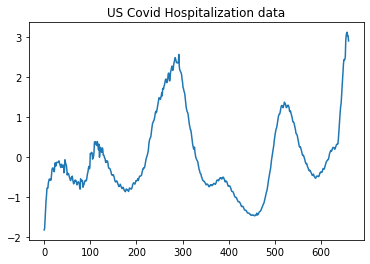

In [54]:
#Plot data
plt.plot(hosp)
plt.title('US Covid Hospitalization data')
plt.show()

In [55]:
#Parameters
last = len(hosp) #Total data points
seqlen = 20 # input size or window size
batchsize = 50 # data period and number of data points
trainbegin = np.random.randint(500) #Get random start day for training

In [56]:
#Preparing training data
Xtrain = np.array(hosp[trainbegin:trainbegin+seqlen])
ytrain = np.array(hosp[trainbegin+seqlen])
for i in range(1, batchsize):
    Xtrain = np.vstack([Xtrain, hosp[trainbegin+i:trainbegin+i+seqlen]])
    ytrain = np.append(ytrain, hosp[trainbegin+i+seqlen])

In [57]:
#Create tensors
X = torch.tensor(Xtrain, dtype=torch.float)
y = torch.tensor(ytrain, dtype=torch.float)

In [58]:
#Input parameters
inputsize = 1
hiddensize = 10
outputsize = 1
epochs = 1000
X2 = torch.reshape(X.T, (seqlen, batchsize, inputsize))

In [59]:
#LSTMCell model
class LSTMCell(nn.Module):
    def __init__(self, inputsize, hiddensize, outputsize, seqlen, batchsize):
        super(LSTMCell, self).__init__()
        self.rnn = nn.LSTMCell(inputsize, hiddensize)
        self.layer2 = nn.Linear(hiddensize, outputsize)
    def forward(self, x):
        hx = torch.randn(batchsize, hiddensize)
        cx = torch.randn(batchsize, hiddensize)
        for i in range(seqlen):
            hx, cx = self.rnn(X2[i], (hx, cx))
        return self.layer2(hx)[:, 0]

In [60]:
#Define model
lstmc = LSTMCell(inputsize, hiddensize, outputsize, seqlen, batchsize)
optimizer_lstmc = optim.Adam(lstmc.parameters())

In [61]:
#Training model
def Train(model,epoch,optimizr,subject):
    for i in range(epoch):
        yhat = model(X2)
        L = F.mse_loss(yhat, y)
        if(i%100 == 0):
            print(f'{subject} Epoch:{i+1} with Loss:{L.item()}')
        optimizr.zero_grad()
        L.backward()
        optimizr.step()
    #Plot
    plotTrain(subject,yhat)

In [62]:
#Training Plot
def plotTrain(subject,yhat):
    plt.plot(y.detach().numpy())
    plt.plot(yhat.detach().numpy())
    plt.legend(['True','Predicted'])
    plt.title(f'{subject} - Training started at {str(trainbegin)}')
    plt.show()

LSTMCell Epoch:1 with Loss:0.15359874069690704
LSTMCell Epoch:101 with Loss:0.017117783427238464
LSTMCell Epoch:201 with Loss:0.012749791145324707
LSTMCell Epoch:301 with Loss:0.01144939661026001
LSTMCell Epoch:401 with Loss:0.011318499222397804
LSTMCell Epoch:501 with Loss:0.011085109785199165
LSTMCell Epoch:601 with Loss:0.010817145928740501
LSTMCell Epoch:701 with Loss:0.010067718103528023
LSTMCell Epoch:801 with Loss:0.010204235091805458
LSTMCell Epoch:901 with Loss:0.009923896752297878


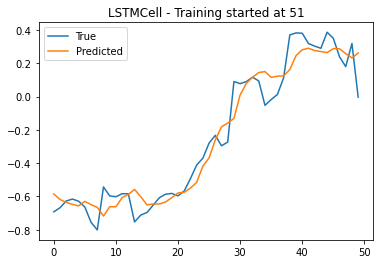

In [63]:
#Train LSTMCell
Train(lstmc,epochs,optimizer_lstmc,'LSTMCell')

In [64]:
#LSTM model
class LSTM(nn.Module):
    def __init__(self, inputsize, hiddensize, outputsize, seqlen, batchsize):
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(inputsize, hiddensize, 2)
        self.layer2 = nn.Linear(hiddensize, outputsize)
    def forward(self, x):
        hx = torch.randn(2, batchsize, hiddensize)
        cx = torch.randn(2, batchsize, hiddensize)
        output, _ = self.rnn(X2, (hx, cx))
        return self.layer2(output[seqlen - 1])[:, 0]

In [65]:
#Define model
lstm = LSTM(inputsize, hiddensize, outputsize, seqlen, batchsize)
optimizer_lstm = optim.Adam(lstm.parameters())

LSTM Epoch:1 with Loss:0.16509146988391876
LSTM Epoch:101 with Loss:0.022141331806778908
LSTM Epoch:201 with Loss:0.013183556497097015
LSTM Epoch:301 with Loss:0.011481757275760174
LSTM Epoch:401 with Loss:0.011680582538247108
LSTM Epoch:501 with Loss:0.011474295519292355
LSTM Epoch:601 with Loss:0.012040279805660248
LSTM Epoch:701 with Loss:0.01083269715309143
LSTM Epoch:801 with Loss:0.010371762327849865
LSTM Epoch:901 with Loss:0.009486568160355091


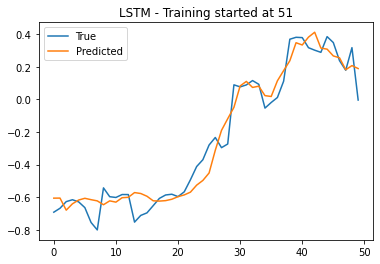

In [66]:
#Train LSTM
Train(lstm,epochs,optimizer_lstm,'LSTM')

In [67]:
#Linear model
class Linear(nn.Module):
    def __init__(self, inputsize, hiddensize, outputsize, seqlen, batchsize):
        super(Linear, self).__init__()
        self.forgetgate = nn.Linear(inputsize + hiddensize, hiddensize)
        self.inputgate = nn.Linear(inputsize + hiddensize, hiddensize)
        self.candidate = nn.Linear(inputsize + hiddensize, hiddensize)
        self.outputgate = nn.Linear(inputsize + hiddensize, hiddensize)
        self.layer2 = nn.Linear(hiddensize, outputsize)
    def forward(self, x):
        hx = torch.randn(batchsize, hiddensize)
        cx = torch.randn(batchsize, hiddensize)
        for j in range(seqlen):
            inp = torch.cat((X2[j], hx), 1)
            i = torch.sigmoid(self.inputgate(inp))
            f = torch.sigmoid(self.forgetgate(inp))
            g = torch.tanh(self.candidate(inp))
            o = torch.sigmoid(self.outputgate(inp))
            cx = f*cx + i*g
            hx = o + torch.tanh(cx)
        return self.layer2(hx)[:, 0]

In [68]:
#Define model
lin = Linear(inputsize, hiddensize, outputsize, seqlen, batchsize)
optimizer_lin = optim.Adam(lin.parameters())

Linear Epoch:1 with Loss:0.16701555252075195
Linear Epoch:101 with Loss:0.01836165226995945
Linear Epoch:201 with Loss:0.012940273620188236
Linear Epoch:301 with Loss:0.011664415709674358
Linear Epoch:401 with Loss:0.01129161100834608
Linear Epoch:501 with Loss:0.010339058935642242
Linear Epoch:601 with Loss:0.010237089358270168
Linear Epoch:701 with Loss:0.009904514998197556
Linear Epoch:801 with Loss:0.009951638989150524
Linear Epoch:901 with Loss:0.009152372367680073


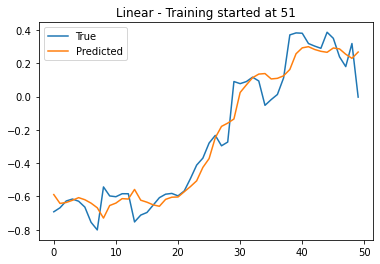

In [69]:
#Train Linear
Train(lin,epochs,optimizer_lin,'Linear')